# Part 5:  Modular arithmetic and primality testing with Python 3.x

Python, like most programming languages, comes with a "mod operation" `%` to compute remainders.  This makes basic modular arithmetic straightforward.  The more interesting aspects -- from the standpoint of programming and number theory -- arise in **algorithms** related to modular arithmetic.  Here we focus on Pingala's algorithm, a method for computing exponents based on an ancient method for enumerating poetic meters.  We analyze the **expected performance** of this algorithm using Python's `timeit` function for timing and `randint` function to randomize input parameters.  We also see how the performance depends on the number of **bits** of the input parameters.  In this way, we gently introduce some practical and theoretical issues in computer science.

We apply this algorithm to implement the Miller-Rabin primality test.  This test can very quickly determine (probabilistically) whether a large (hundreds or thousands of digits!) number is prime.  Our implementation is deterministic for smaller (under 64 bits) numbers.  This programming tutorial complements Chapters 5 and 6 of [An Illustrated Theory of Numbers](http://illustratedtheoryofnumbers.com/index.html).  


## Table of Contents

- [Calculations in modular arithmetic](#modcalc)
- [The Miller-Rabin Primality Test](#millerrabin)

<a id='modcalc'></a>

## Calculations in modular arithmetic

### The mod (%) operator

For basic modular arithmetic, one can use Python's "mod operator" `%` to obtain remainders.  There is a conceptual difference between the "mod" of computer programming and the "mod" of number theorists.  In computer programming, "mod" is typically the operator which outputs the remainder after division.  So for a computer scientist, "23 mod 5 = 3", because 3 is the remainder after dividing 23 by 5.

Number theorists (starting with Gauss) take a radical conceptual shift.  A number theorist would write $23 \equiv 3$ mod $5$, to say that 23 is **congruent** to 3 modulo 5.  In this sense "mod 5" (standing for "modulo 5") is a [prepositional phrase](https://www.economist.com/blogs/johnson/2012/08/grammar), describing the "modular world" in which 23 is the same as ("congruent to") 3.

To connect these perspectives, we would say that the computer scientist's statement "23 mod 5 = 3" gives the **natural representative** 3 for the number 23 in the mathematician's "ring of integers mod 5".  (Here "ring" is a term from abstract algebra.)

In [1]:
23 % 5  # What is the remainder after dividing 23 by 5?  What is the natural representative of 23 modulo 5?

3

The miracle that makes modular arithmetic work is that the end-result of a computation "mod m" is not changed if one works "mod m" along the way.  At least this is true if the computation only involves **addition, subtraction, and multiplication**.

In [2]:
((17 + 38) * (105 - 193)) % 13  # Do a bunch of stuff, then take the representative modulo 13.

9

In [3]:
(((17%13) + (38%13)) * ((105%13) - (193%13)) ) % 13 # Working modulo 13 along the way.

9

It might seem tedious to carry out this "reduction mod m" at every step along the way.  But the advantage is that you never have to work with numbers much bigger than the modulus (m) if you can reduce modulo m at each step.

For example, consider the following computation.

In [4]:
3**999 # A very large integer.

440690273160268878963485086584048121988474010917382722554973456075609532448901633180259437950202687321303259232290860785316984860700206303955114241752651224675873408399440267959338258076321613758130133372529539347042982605207698146020522057684695558163502059375160114801849018132346298605821789418305378740276756187926194096742805466102629298972852134694966312536457747390615453312898505588339646862703020142029890479621367604783461882915721944003538122044057700922967618406667

In [5]:
(3**999) % 1000  # What are the last 3 digits of 3 raised to the 999 power?

667

To compute the last three digits of $3^{999}$, Python works with some very large integers along the way.  But what if we could reduce modulo 1000 at every step?  Then, as Python multiplies terms, it will never have to multiply numbers bigger than 1000.  Here is a brute-force implementation.

In [6]:
P = 1  # The "running product" starts at 1.
for i in range(999):  # We repeat the following line 999 times, as i traverses the list [0,1,...,998].
    P = (P * 3)%1000  # We reduce modulo 1000 along the way!
print(P)

667


In this computation, Python never has to work with long integers.  Computations with long integers are time-consuming, and unnecessary if you only care about the result of a computation modulo a small number m.

### Performance analysis

The above loop works quickly, but it is far from optimal.  Let's carry out some **performance analysis** by writing two `powermod` functions.

In [7]:
def powermod_1(base, exponent, modulus):  # The naive approach.
    return (base**exponent) % modulus 

In [8]:
def powermod_2(base, exponent, modulus):
    P = 1 # Start the running product at 1.
    e = 0
    for i in range(exponent):
        P = (P * base) % modulus
    return P

Now let's compare the performance of these two functions.  It's also good to double check the code in `powermod_2` and run it to check the results.  The reason is that loops like this are classic sources of [Off by One Errors](https://en.wikipedia.org/wiki/Off-by-one_error).  One has to unravel the loop carefully to be completely certain, and testing is a necessity to avoid bugs!

We can compare the performance of the two functions with identical input parameters below.

In [9]:
%timeit powermod_1(3,999,1000)

The slowest run took 5.27 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 2.25 µs per loop


In [10]:
%timeit powermod_2(3,999,1000)

10000 loops, best of 3: 120 µs per loop


The second `powermod` function was probably much slower, even though we reduced the size of the numbers along the way.  But perhaps we just chose some input parameters (3,999,1000) which were inconvenient for the second function.  To compare the performance of the two functions, it would be useful to try many different inputs.

For this, we use Python's timeit features in a different way.  Above we used the "magic" `%timeit` to time a line of code.  The magic command `%timeit` is convenient but limited in flexibility.  Here we use a larger Python `timeit` package which we import (as `TI`) and demonstrate below.

In [11]:
import timeit as TI

In [12]:
TI.timeit('powermod_1(3,999,1000)', "from __main__ import powermod_1", number=10000)

0.045027135998680023

In [13]:
TI.timeit('powermod_2(3,999,1000)', "from __main__ import powermod_2", number=10000)

1.2610167899983935

The syntax of the timeit *function* is a bit challenging.  The first parameter is the Python code which we are timing (as a string), in this case `powermod_*(3,999,1000)`.  The second parameter probably looks strange.  It exists because the timeit function sets up a little isolation chamber to run the code -- within this isolation chamber, it only knows standard Python commands and not the new functions you've created.  So you have to *import* your functions (`powermod_1` or `powermod_2`) into its isolation box.  Where are these imported from?  They are contained in `__main__` which is the location of all of your other code.  Finally, the third parameter `number` is the number of times the timeit function will repeat the code (by default, this might be a large number like 1000000).  

The output of the timeit function is a *float*, which represents the number of seconds taken for *all* of the repetitions.  Contrast this with the timeit magic, which found the average.  So you need to divide by the `number` parameter (10000 in the above examples) to find the average time taken.

Using the timeit *function*, we can compare the performance of the two `powermod` functions on multiple inputs, wrapping the whole comparison process in a bigger function.  We choose our inputs *randomly* in order to estimate the **expected performance** of our functions.  To choose random inputs, Python has a package aptly called random.

In [14]:
from random import randint # randint chooses random integers.

In [15]:
print("My number is {}".format(randint(1,10))) # Run this line many times over to see what happens!

My number is 4


The `randint(a,b)` command chooses a random integer between `a` and `b`, inclusive!  Unlike the `range(a,b)` command which iterates from `a` to `b-1`, the `randint` command includes both `a` and `b` as possibilities.  The following lines iterate the `randint(1,10)` and keep track of how often each output occurs.  The resulting *frequency distribution* should be nearly flat, i.e., each number between 1 and 10 should occur about 10% of the time.

In [16]:
Freq = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0}  # We like to use a dictionary here.
for t in range(10000):
    n = randint(1,10) # Choose a random number between 1 and 10.
    Freq[n] = Freq[n] + 1

print(Freq)

{1: 997, 2: 984, 3: 951, 4: 1002, 5: 1009, 6: 1016, 7: 1016, 8: 999, 9: 1028, 10: 998}


For fun, and as a template for other explorations, we plot the frequencies in a histogram.  

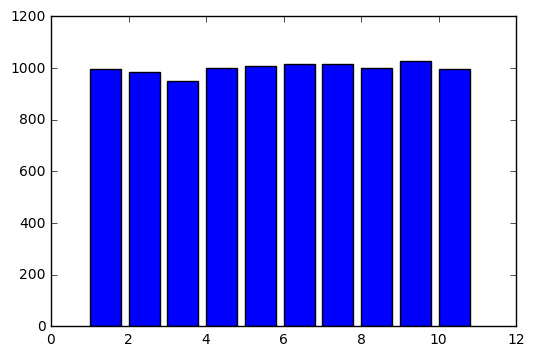

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.bar(Freq.keys(), Freq.values()) # The keys 1,...,10 are used as bins.  The values are used as bar heights.
plt.show()

Putting together the `randint` function and the `timeit` function, we can compare the performance of `powermod_1` and `powermod_2` when given random inputs.

In [18]:
time_1 = 0 # Tracking the time taken by the powermod_1 function.
time_2 = 0 # Tracking the time taken by the powermod_2 function.
for t in range(1000): # One thousand samples are taken!
    base = randint(10,99) # A random 2-digit base.
    exponent = randint(1000,1999) # A random 3-digit exponent.
    modulus = randint(1000,1999) # A random 3-digit modulus.
    
    # Note in the lines below that we have to import the functions powermod_1, powermod_2 and 
    # the variables base, exponent, modulus, into the isolation chamber used by timeit.
    # We set number=10 to allow 10 trials of each function on each sample input.
    # We do a head-to-head comparison of the two functions on the same inputs!
    # Note that when the lines get too long in Python, you can press <enter>/<return> to start a new line.
    # Python will ignore the line break.  Just keep things indented for clarity.
    
    time_1 = time_1 + TI.timeit('powermod_1(base,exponent,modulus)', 
                              "from __main__ import powermod_1, base, exponent, modulus", number=10)
    time_2 = time_2 + TI.timeit('powermod_2(base,exponent,modulus)', 
                              "from __main__ import powermod_2, base, exponent, modulus", number=10)
    
print("powermod_1 took {} seconds.".format(time_1))
print("powermod_2 took {} seconds.".format(time_2)) # Which is faster?

powermod_1 took 0.20681001695629675 seconds.
powermod_2 took 2.036145739031781 seconds.


Now we can be pretty sure that the `powermod_1` function is faster (perhaps by a factor of 8-10) than the `powermod_2` function we designed.  At least, this is the case for inputs in the 2-3 digit range that we sampled.  But why?  We reduced the complexity of the calculation by using the mod operation `%` throughout.  Here are a few issues one might suspect.

1.  The mod operation itself takes a bit of time.  Maybe that time added up in `powermod_2`?
2.  The Python power operation `**` is highly optimized already, and outperforms our while loop.
3.  We used more multiplications than necessary.

It turns out that the mod operation is extremely fast... as in *nanoseconds* (billionths of a second) fast.

In [19]:
%timeit 1238712 % 1237

100000000 loops, best of 3: 15.1 ns per loop


So the speed difference is not due to the number of mod operations.  But the other issues are relevant.  The Python developers have worked hard to make Python run fast -- built-in operations like `**` will almost certainly be faster than any function that you write with a loop in Python.  The developers have written programs in the **C programming language** (typically) to implement operations like `**` (see the [CPython implementation](https://hg.python.org/cpython/file/c7163a7f7cd2/Python/bltinmodule.c#l1505), if you wish); their programs have been **compiled** into **machine code** -- the basic sets of instructions that your computer understands (and that are not meant for people to understand).  When you call a built-in operation like `**`, Python just tells your computer to run the developers' optimized and **precompiled** machine code... this is very fast!  When you run your own loop, Python is basically converting the code to machine code "on the fly" and this is slower.

Still, it is unfortunate to use long integers if you ask Python to compute `(3**999) % 1000`.  The good news is that such modular exponents are so frequently used that the Python developers have a built-in operation:  the `pow` function.

The `pow` function has two versions.  The simplest version `pow(b,e)` raises `b` to the `e` power.  It is the same as computing `b ** e`.  But it also has a modular version!  The command `pow(b,e,m)` raises `b` to the `e` modulo `m`, efficiently reducing modulo `m` along the way.

In [20]:
pow(3,999)  # A long number.

440690273160268878963485086584048121988474010917382722554973456075609532448901633180259437950202687321303259232290860785316984860700206303955114241752651224675873408399440267959338258076321613758130133372529539347042982605207698146020522057684695558163502059375160114801849018132346298605821789418305378740276756187926194096742805466102629298972852134694966312536457747390615453312898505588339646862703020142029890479621367604783461882915721944003538122044057700922967618406667

In [21]:
pow(3,999,1000) # The result, modulo 1000.  

667

In [22]:
pow(3,999) % 1000 # The old way

667

In [23]:
%timeit pow(3,999,1000)

The slowest run took 4.96 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 1.46 µs per loop


In [24]:
%timeit pow(3,999) % 1000

The slowest run took 5.29 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 2.23 µs per loop


The `pow(b,e,m)` command should give a significant speedup, as compared to the `pow(b,e)` command.  Remember that ns stands for nanoseconds (billionths of a second) and µs stands for microseconds (millionths of a second).

Exponentiation runs so quickly because not only is Python reducing modulo `m` along the way, it is performing a surprisingly small number of multiplications.  In our loop approach, we computed $3^{999}$ by multiplying repeatedly.  There were 999 multiplications!  But consider this carefully -- did we need to perform so many multiplications?  Can you compute $3^{999}$ with far fewer multiplications?  What if you can place results in memory along the way?  

In the next section, we study a very efficient **algorithm** for computing such exponents.  The goal in designing a good algorithm is to create something which runs **quickly**, minimizes the need for **memory**, and runs reliably for all the necessary input values.  Often there are trade-offs between speed and memory usage, but our exponentiation algorithm will be excellent in both respects.  The ideas go back to [Pingala](https://en.wikipedia.org/wiki/Pingala), an Indian mathematician of the 2nd or 3rd century BCE, who developed his ideas to enumerate possible poetic meters (arrangements of long and short syllables into verses of a given length).  

You may wonder why it is necessary to learn the algorithm at all, if Python has an optimized algorithm built into its `pow` command.  First, it is interesting!  But also, we will need to understand the algorithm in finer detail to implement the Miller-Rabin test:  a way of quickly testing whether very large numbers are prime.

### Exercises

1.  Adapt the `solve_LDE` function from [PwNT Notebook 2](http://illustratedtheoryofnumbers.com/prog.html#notebooks), in order to write a function `modular_inverse(a,m)` which computes the multiplicative inverse of `a` modulo `m` (if they are coprime).

2.  Use the `timeit` and `randint` functions to investigate how the speed of the command `pow(a,e,m)` depends on how many digits the numbers `a`, `e`, and `m` have.  Note that `randint(10**(d-1), 10**d - 1)` will produce a random integer with `d` digits.  If you hold two of these variables fixed, consider how the time changes as the third variable is changed.  

3.  Imagine that you are going to compute $3^{100}$ by multiplying positive integers together.  If each multiplication operation costs 1 dollar, how much money do you need to spend?  You can assume that **remembering** previously computed numbers is free.  What if it costs 1 dollar each time you need to place a number into memory or recover a number from memory?  What is the cheapest way to compute $3^{100}$?

<a id='millerrabin'></a>

## The Miller-Rabin primality test

### Fermat's Little Theorem and the ROO property of primes

Fermat's Little Theorem states that if $p$ is a prime number, and $GCD(a,p) = 1$, then $$a^{p-1} \equiv 1 \text{ mod } p.$$
Under the assumptions above, if we ask Python to compute `(a**(p-1))%p`, or even better, `pow(a,p-1,p)`, the result should be 1.  We use and refine this idea to develop a powerful and practical primality test.  Let's begin with a few checks of Fermat's Little Theorem.

In [25]:
pow(3,36,37)  # a = 3, p = 37, p-1 = 36

1

In [26]:
pow(17,100,101) # 101 is prime.

1

In [27]:
pow(303, 100, 101)  # Why won't we get 1?

0

In [29]:
pow(5,90,91) # What's the answer?

64

In [30]:
pow(7,12318, 12319) # What's the answer?

1331

We can learn something from the previous two examples.  Namely, 91 and 12319 are **not** prime numbers.  We say that 7 **witnesses** the non-primality of 12319.  Moreover, we learned this fact without actually finding a factor of 12319!  Indeed, the factors of 12319 are 97 and 127, which have no relationship to the "witness" 7.

In this way, Fermat's Little Theorem -- a statement about prime numbers -- can be turned into a way of discovering that numbers are not prime.  After all, if $p$ is not prime, then what are the chances that $a^{p-1} \equiv 1$ mod $p$ by coincidence?  

In [31]:
pow(3,90,91)

1

Well, ok.  Sometimes coincidences happen.  We say that 3 is a **bad witness** for 91, since 91 is not prime, but $3^{90} \equiv 1$ mod $91$.  But we could try multiple bases (witnesses).  We can expect that someone (some base) will witness the nonprimality.  Indeed, for the non-prime 91 there are many good witnesses (ones that detect the nonprimality).

In [32]:
for witness in range(1,20):
    flt = pow(witness, 90, 91)
    if flt == 1:
        print("{} is a bad witness.".format(witness))
    else:
        print("{} raised to the 90th power equals {}, mod 91".format(witness, flt))

1 is a bad witness.
2 raised to the 90th power equals 64, mod 91
3 is a bad witness.
4 is a bad witness.
5 raised to the 90th power equals 64, mod 91
6 raised to the 90th power equals 64, mod 91
7 raised to the 90th power equals 77, mod 91
8 raised to the 90th power equals 64, mod 91
9 is a bad witness.
10 is a bad witness.
11 raised to the 90th power equals 64, mod 91
12 is a bad witness.
13 raised to the 90th power equals 78, mod 91
14 raised to the 90th power equals 14, mod 91
15 raised to the 90th power equals 64, mod 91
16 is a bad witness.
17 is a bad witness.
18 raised to the 90th power equals 64, mod 91
19 raised to the 90th power equals 64, mod 91


For some numbers -- the [Carmichael numbers](https://en.wikipedia.org/wiki/Carmichael_number) -- there are more bad witnesses than good witnesses.  For example, take the Carmichael number 41041, which is not prime ($41041 = 7 \cdot 11 \cdot 13 \cdot 41$).  

In [33]:
for witness in range(1,20):
    flt = pow(witness, 41040, 41041)
    if flt == 1:
        print("{} is a bad witness.".format(witness))
    else:
        print("{} raised to the 41040th power equals {}, mod 41041".format(witness, flt))

1 is a bad witness.
2 is a bad witness.
3 is a bad witness.
4 is a bad witness.
5 is a bad witness.
6 is a bad witness.
7 raised to the 41040th power equals 29316, mod 41041
8 is a bad witness.
9 is a bad witness.
10 is a bad witness.
11 raised to the 41040th power equals 18656, mod 41041
12 is a bad witness.
13 raised to the 41040th power equals 22100, mod 41041
14 raised to the 41040th power equals 29316, mod 41041
15 is a bad witness.
16 is a bad witness.
17 is a bad witness.
18 is a bad witness.
19 is a bad witness.


For Carmichael numbers, it turns out that finding a good witness is just as difficult as finding a factor.  Although Carmichael numbers are rare, they demonstrate that Fermat's Little Theorem by itself is not a great way to be certain of primality.  Effectively, Fermat's Little Theorem can often be used to quickly prove that a number **is not prime**... but it is not so good if we want to be sure that a number **is prime**.

The Miller-Rabin primality test will refine the Fermat's Little Theorem test, by cleverly taking advantage of another property of prime numbers.  We call this the ROO (Roots Of One) property:  if $p$ is a prime number, and $x^2 \equiv 1$ mod $p$, then $x \equiv 1$ or $x \equiv -1$ mod $p$.

In [34]:
for x in range(41):  
    if x*x % 41 == 1:
        print("{} squared is congruent to 1, mod 41.".format(x))  # What numbers do you think will be printed?

1 squared is congruent to 1, mod 41.
40 squared is congruent to 1, mod 41.


Note that we use "natural representatives" when doing modular arithmetic in Python.  So the only numbers whose square is 1 mod 41 are 1 and 40.  (Note that 40 is the natural representative of -1, mod 41).  If we consider the "square roots of 1" with a composite modulus, we find more (as long as the modulus has at least two odd prime factors).

In [35]:
for x in range(91):
    if x*x % 91 == 1:
        print("{} squared is congruent to 1, mod 91.".format(x))  # What numbers do you think will be printed?

1 squared is congruent to 1, mod 91.
27 squared is congruent to 1, mod 91.
64 squared is congruent to 1, mod 91.
90 squared is congruent to 1, mod 91.


We have described two properties of prime numbers, and therefore two possible indicators that a number is not prime.

1.  If $p$ is a number which violates Fermat's Little Theorem, then $p$ is not prime.

2.  If $p$ is a number which violates the ROO property, then $p$ is not prime.

The Miller Rabin test will combine these indicators.  But first we have to introduce an ancient algorithm for exponentiation.

### Pingala's exponentiation algorithm

If we wish to compute $5^{90}$ mod $91$, without the `pow` command, we don't have to carry out 90 multiplications.  Instead, we carry out **Pingala's algorithm**.  To understand this algorithm, we begin with the desired exponent (e.g. $e=90$), and carry out a series of steps:  replace $e$ by $e/2$ if $e$ is even, and replace $e$ by $(e-1) / 2$ if $e$ is odd.  Repeat this until the exponent is decreased to zero.  The following function carries out this process on any input $e$.

In [36]:
def Pingala(e):
    current_number = e
    while current_number > 0:
        if current_number%2 == 0:
            current_number = current_number // 2
            print("Exponent {} BIT 0".format(current_number))
        if current_number%2 == 1:
            current_number = (current_number - 1) // 2
            print("Exponent {} BIT 1".format(current_number))

In [37]:
Pingala(90)

Exponent 45 BIT 0
Exponent 22 BIT 1
Exponent 11 BIT 0
Exponent 5 BIT 1
Exponent 2 BIT 1
Exponent 1 BIT 0
Exponent 0 BIT 1


The codes "BIT 1" and "BIT 0" tell us what happened at each step, and allow the process to be reversed.  In a line with BIT 0, the exponent gets **doubled** as one goes **up** one line (e.g., from 11 to 22).  In a line with BIT 1, the exponent gets **doubled then increased by 1** as one goes **up** one line (e.g., from 2 to 5).

We can use these BIT codes in order to compute an exponent.  Below, we follow the BIT codes to compute $5^{90}$.

In [38]:
n = 1  # This is where we start.
n = n*n * 5 # BIT 1 is interpreted as square-then-multiply-by-5, since the exponent is doubled then increased by 1.
n = n*n  # BIT 0 is interpreted as squaring, since the exponent is doubled.
n = n*n * 5 # BIT 1
n = n*n * 5 # BIT 1 again.
n = n*n # BIT 0
n = n*n * 5 # BIT 1
n = n*n # BIT 0

In [39]:
print(n)  # What we just computed.
print(5**90) # I hope these match!!

807793566946316088741610050849573099185363389551639556884765625
807793566946316088741610050849573099185363389551639556884765625


Note that along the way, we carried out 11 multiplications (count the `*` symbols), and didn't have to remember too many numbers along the way.  So this process was efficient in both time and memory.  We just followed the BIT code.  The number of multiplications is bounded by twice the number of BITs, since each BIT requires at most two multiplications (squaring then multiplication by 5) to execute.

Why did we call the code a BIT code?  It's because the code consists precisely of the bits (binary digits) of the exponent 90!  Since computers store numbers in binary, the computer "knows" the BIT code as soon as it knows the exponent.  In Python, the `bin` command recovers the binary expansion of a number.

In [40]:
bin(90)  # Compare this to the sequence of bits, from bottom up.

'0b1011010'

Python outputs binary expansions as strings, beginning with `'0b'`.  To summarize, we can compute an exponent like $b^e$ by the following process:

**Pingala's Exponentiation Algorithm**

1.  Set the number to 1.

2.  Read the bits of $e$, from left to right.  
    a. When the bit is zero, square the number.   
    b. When the bit is one, square the number, then multiply by $b$.
    
3.  Output the resulting number.

In [41]:
def pow_Pingala(base,exponent):
    result = 1
    bitstring = bin(exponent)[2:] # Chop off the '0b' part of the binary expansion of exponent
    for bit in bitstring: # Iterates through the "letters" of the string.  Here the letters are '0' or '1'.
        if bit == '0':
            result = result*result
        if bit == '1':
            result = result*result * base
    return result

In [42]:
pow_Pingala(5,90)

807793566946316088741610050849573099185363389551639556884765625

It is straightforward to modify Pingala's algorithm to compute exponents in modular arithmetic.  Just reduce along the way.

In [43]:
def powmod_Pingala(base,exponent,modulus):
    result = 1
    bitstring = bin(exponent)[2:] # Chop off the '0b' part of the binary expansion of exponent
    for bit in bitstring: # Iterates through the "letters" of the string.  Here the letters are '0' or '1'.
        if bit == '0':
            result = (result*result) % modulus 
        if bit == '1':
            result = (result*result * base) % modulus
    return result

In [44]:
powmod_Pingala(5,90,91)

64

Let's compare the performance of our new modular exponentiation algorithm.

In [45]:
%timeit powmod_Pingala(3,999,1000)  # Pingala's algorithm, modding along the way.

The slowest run took 5.10 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 2.43 µs per loop


In [46]:
%timeit powermod_1(3,999,1000)  # Raise to the power, then mod, using Python built-in exponents.

The slowest run took 5.54 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 2.24 µs per loop


In [47]:
%timeit powermod_2(3,999,1000)  #  Multiply 999 times, modding along the way.

10000 loops, best of 3: 120 µs per loop


In [48]:
%timeit pow(3,999,1000)  #  Use the Python built-in modular exponent.

The slowest run took 4.71 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 1.46 µs per loop


The fully built-in modular exponentiation `pow(b,e,m)` command is probably the fastest.  But our implementation of Pingala's algorithm isn't bad -- it probably beats the simple `(b**e) % m` command (in the `powermod_1` function), and it's certainly faster than our naive loop in `powermod_2`.  

One can quantify the efficiency of these algorithms by analyzing how the **time** depends on the **size** of the input parameters.  For the sake of exposition, let us keep the base and modulus constant, and consider how the time varies with the size of the exponent.

As a function of the exponent $e$, our `powmod_Pingala` algorithm required some number of multiplications, bounded by twice the number of bits of $e$.  The number of bits of $e$ is approximately $\log_2(e)$.  The size of the numbers multiplied is bounded by the size of the (constant) modulus.  In this way, the time taken by the `powmod_Pingala` algorithm should be $O(\log(e))$, meaning bounded by a constant times the logarithm of the exponent.

Contrast this with the slow `powermod_2` algorithm, which performs $e$ multiplications, and has thus has runtime $O(e)$.

### The Miller-Rabin test

Pingala's algorithm is effective for computing exponents, in ordinary arithmetic or in modular arithmetic.  In this way, we can look for violations of Fermat's Little Theorem as before, to find witnesses to non-primality.  But if we look more closely at the algorithm... we can sometimes find violations of the ROO property of primes.  This strengthens the primality test.

To see this, we create out a "verbose" version of Pingala's algorithm for modular exponentiation.

In [49]:
def powmod_verbose(base, exponent, modulus):
    result = 1
    print("Computing {} raised to {}, modulo {}.".format(base, exponent, modulus))
    print("The current number is {}".format(result))
    bitstring = bin(exponent)[2:] # Chop off the '0b' part of the binary expansion of exponent
    for bit in bitstring: # Iterates through the "letters" of the string.  Here the letters are '0' or '1'.
        sq_result = result*result % modulus  # We need to compute this in any case.
        if bit == '0':
            print("BIT 0:  {} squared is congruent to {}, mod {}".format(result, sq_result, modulus))
            result = sq_result 
        if bit == '1':
            newresult = (sq_result * base) % modulus
            print("BIT 1:  {} squared times {} is congruent to {}, mod {}".format(result, base, newresult, modulus))
            result = newresult
    return result

In [50]:
powmod_verbose(2,560,561)  # 561 is a Carmichael number.

Computing 2 raised to 560, modulo 561.
The current number is 1
BIT 1:  1 squared times 2 is congruent to 2, mod 561
BIT 0:  2 squared is congruent to 4, mod 561
BIT 0:  4 squared is congruent to 16, mod 561
BIT 0:  16 squared is congruent to 256, mod 561
BIT 1:  256 squared times 2 is congruent to 359, mod 561
BIT 1:  359 squared times 2 is congruent to 263, mod 561
BIT 0:  263 squared is congruent to 166, mod 561
BIT 0:  166 squared is congruent to 67, mod 561
BIT 0:  67 squared is congruent to 1, mod 561
BIT 0:  1 squared is congruent to 1, mod 561


1

The function has displayed every step in Pingala's algorithm.  The final result is that $2^{560} \equiv 1$ mod $561$.  So in this sense, $2$ is a bad witness.  For $561$ is not prime (3 is a factor), but it does not violate Fermat's Little Theorem when $2$ is the base.

But within the verbose output above, there is a violation of the ROO property.  The penultimate line states that "67 squared is congruent to 1, mod 561".  But if 561 were prime, only 1 and 560 are square roots of 1.  Hence this penultimate line implies that 561 is not prime (again, without finding a factor!).  

This underlies the Miller-Rabin test.  We carry out Pingala's exponentiation algorithm to compute $b^{p-1}$ modulo $p$.  If we find a violation of ROO along the way, then the test number $p$ is not prime.  And if, at the end, the computation does not yield $1$, we have found a Fermat's Little Theorem (FLT) violation, and the test number $p$ is not prime.

The function below implements the Miller-Rabin test on a number $p$, using a given base.

In [51]:
def Miller_Rabin(p, base):
    '''
    Tests whether p is prime, using the given base.
    The result False implies that p is definitely not prime.
    The result True implies that p **might** be prime.
    It is not a perfect test!
    '''
    result = 1
    exponent = p-1
    modulus = p
    bitstring = bin(exponent)[2:] # Chop off the '0b' part of the binary expansion of exponent
    for bit in bitstring: # Iterates through the "letters" of the string.  Here the letters are '0' or '1'.
        sq_result = result*result % modulus  # We need to compute this in any case.
        if sq_result == 1:
            if (result != 1) and (result != exponent):  # Note that exponent is congruent to -1, mod p.
                return False  # a ROO violation occurred, so p is not prime
        if bit == '0':
            result = sq_result 
        if bit == '1':
            result = (sq_result * base) % modulus
    if result != 1:
        return False  # a FLT violation occurred, so p is not prime.
    
    return True  # If we made it this far, no violation occurred and p might be prime.

In [52]:
 Miller_Rabin(101,6)

True

How good is the Miller-Rabin test?  Will this modest improvement (looking for ROO violations) improve the reliability of witnesses?  Let's see how many witnesses observe the nonprimality of 41041.

In [53]:
for witness in range(2,20):
    MR = Miller_Rabin(41041, witness) # 
    if MR: 
        print("{} is a bad witness.".format(witness))
    else:
        print("{} detects that 41041 is not prime.".format(witness))

2 detects that 41041 is not prime.
3 detects that 41041 is not prime.
4 detects that 41041 is not prime.
5 detects that 41041 is not prime.
6 detects that 41041 is not prime.
7 detects that 41041 is not prime.
8 detects that 41041 is not prime.
9 detects that 41041 is not prime.
10 detects that 41041 is not prime.
11 detects that 41041 is not prime.
12 detects that 41041 is not prime.
13 detects that 41041 is not prime.
14 detects that 41041 is not prime.
15 detects that 41041 is not prime.
16 is a bad witness.
17 detects that 41041 is not prime.
18 detects that 41041 is not prime.
19 detects that 41041 is not prime.


In fact, one can prove that at least 3/4 of the witnesses will detect the non-primality of any non-prime.  Thus, if you keep on asking witnesses at random, your chances of detecting non-primality increase exponentially!  In fact, the witness 2 suffices to check whether any number is prime or not up to 2047.  In other words, if $p < 2047$, then $p$ is prime if and only if `Miller_Rabin(p,2)` is `True`.  Just using the witnesses 2 and 3 suffice to check primality for numbers up to a million (1373653, to be precise, according to [Wikipedia](https://en.wikipedia.org/wiki/Miller%E2%80%93Rabin_primality_test).)

The general strategy behind the Miller-Rabin test then is to use just a few witnesses for smallish potential primes (say, up to $2^{64}$).  For larger numbers, try some number $x$ (like 20 or 50) random bases.  If the tested number **is** composite, then the probability of all witnesses reporting `True` is is less than $1 / 4^x$.  With 50 random witnesses, the chance that a composite number tests as prime is less than $10^{-30}$.  

Note that these are statements about **conditional probability**.  In more formal language,
$$\text{Prob} \left( \text{tests prime} \ \vert \ \text{ is composite} \right) < \frac{1}{4^{\# \text{witnesses} } }.$$
As those who study medical testing know, this probability differs from the probability that most people care about:  the probability that a number is prime, given that it tests prime.  The relationship between the two probabilities is given by Bayes Theorem, and depends on the **prevalence** of primes among the sample.  If our sample consists of numbers of absolute value about $N$, then the prevalence of primes will be about $1 / \log(N)$, and the probability of primality given a positive test result can be approximated. 
$$\text{Prob} \left( \text{ is prime } \ \vert \ \text{ tests prime } \right) > 1 - \frac{\log(N) - 1}{4^{\# \text{witnesses}}}.$$
As one chooses more witnesses, this probability becomes extremely close to $1$.

In [54]:
from mpmath import *
# The mpmath package allows us to compute with arbitrary precision!
# It has specialized functions for log, sin, exp, etc.., with arbitrary precision.
# It is probably installed with your version of Python.

def prob_prime(N, witnesses):
    '''
    Conservatively estimates the probability of primality, given a positive test result.
    N is an approximation of the size of the tested number.
    witnesses is the number of witnesses.
    '''
    mp.dps = witnesses # mp.dps is the number of digits of precision.  We adapt this as needed for input.
    prob_prime = 1 - (log(N) - 1) / (4**witnesses)
    print(str(100*prob_prime)+"% chance of primality") # Use str to convert mpmath float to string for printing.

In [55]:
prob_prime(10**100, 50) # Chance of primality with 50 witnesses, if a 100-digit number is tested.

99.999999999999999999999999981914692482445195916316% chance of primality


We implement the Miller-Rabin test for primality in the `is_prime` function below.

In [56]:
def is_prime(p, witnesses=50):  # witnesses is a parameter with a default value.
    '''
    Tests whether a positive integer p is prime.
    For p < 2^64, the test is deterministic, using known good witnesses.
    Good witnesses come from a table at Wikipedia's article on the Miller-Rabin test,
    based on research by Pomerance, Selfridge and Wagstaff, Jaeschke, Jiang and Deng.
    For larger p, a number (by default, 50) of witnesses are chosen at random.
    '''
    if (p%2 == 0): # Might as well take care of even numbers at the outset!
        if p == 2:
            return True
        else:
            return False 
    
    if p > 2**64:  # We use the probabilistic test for large p.
        trial = 0
        while trial < witnesses:
            trial = trial + 1
            witness = randint(2,p-2) # A good range for possible witnesses
            if Miller_Rabin(p,witness) == False:
                return False
        return True
    
    else:  # We use a determinisic test for p <= 2**64.
        verdict = Miller_Rabin(p,2)
        if p < 2047:
            return verdict # The witness 2 suffices.
        verdict = verdict and Miller_Rabin(p,3)
        if p < 1373653:
            return verdict # The witnesses 2 and 3 suffice.
        verdict = verdict and Miller_Rabin(p,5)
        if p < 25326001:
            return verdict # The witnesses 2,3,5 suffice.
        verdict = verdict and Miller_Rabin(p,7)
        if p < 3215031751:
            return verdict # The witnesses 2,3,5,7 suffice.
        verdict = verdict and Miller_Rabin(p,11)
        if p < 2152302898747:
            return verdict # The witnesses 2,3,5,7,11 suffice.
        verdict = verdict and Miller_Rabin(p,13)
        if p < 3474749660383:
            return verdict # The witnesses 2,3,5,7,11,13 suffice.
        verdict = verdict and Miller_Rabin(p,17)
        if p < 341550071728321:
            return verdict # The witnesses 2,3,5,7,11,17 suffice.
        verdict = verdict and Miller_Rabin(p,19) and Miller_Rabin(p,23)
        if p < 3825123056546413051:
            return verdict # The witnesses 2,3,5,7,11,17,19,23 suffice.
        verdict = verdict and Miller_Rabin(p,29) and Miller_Rabin(p,31) and Miller_Rabin(p,37)
        return verdict # The witnesses 2,3,5,7,11,17,19,23,29,31,37 suffice for testing up to 2^64. 
    

In [57]:
is_prime(1000000000000066600000000000001)  # This is Belphegor's prime.

True

How fast is our new `is_prime` function?  Let's give it a try.

In [58]:
%timeit is_prime(234987928347928347928347928734987398792837491)

10000 loops, best of 3: 91.7 µs per loop


In [59]:
%timeit is_prime(1000000000000066600000000000001)

100 loops, best of 3: 2.63 ms per loop


The results will probably on the order of a millisecond, perhaps even a tenth of a millisecond ($10^{-4}$ seconds) for non-primes!  That's much faster than looking for factors, for numbers of this size.  In this way, we can test primality of numbers of hundreds of digits!

For an application, let's find some Mersenne primes.  Recall that a Mersenne prime is a prime of the form $2^p - 1$.  Note that when $2^p - 1$ is prime, it must be the case that $p$ is a prime too.  We will quickly find the Mersenne primes with $p$ up to 1000 below!

In [60]:
for p in range(1,1000):
    if is_prime(p):  # We only need to check these p.
        M = 2**p - 1 # A candidate for a Mersenne prime.
        if is_prime(M):
            print("2^{} - 1 = {} is a Mersenne prime.".format(p,M))

2^2 - 1 = 3 is a Mersenne prime.
2^3 - 1 = 7 is a Mersenne prime.
2^5 - 1 = 31 is a Mersenne prime.
2^7 - 1 = 127 is a Mersenne prime.
2^13 - 1 = 8191 is a Mersenne prime.
2^17 - 1 = 131071 is a Mersenne prime.
2^19 - 1 = 524287 is a Mersenne prime.
2^31 - 1 = 2147483647 is a Mersenne prime.
2^61 - 1 = 2305843009213693951 is a Mersenne prime.
2^89 - 1 = 618970019642690137449562111 is a Mersenne prime.
2^107 - 1 = 162259276829213363391578010288127 is a Mersenne prime.
2^127 - 1 = 170141183460469231731687303715884105727 is a Mersenne prime.
2^521 - 1 = 6864797660130609714981900799081393217269435300143305409394463459185543183397656052122559640661454554977296311391480858037121987999716643812574028291115057151 is a Mersenne prime.
2^607 - 1 = 531137992816767098689588206552468627329593117727031923199444138200403559860852242739162502265229285668889329486246501015346579337652707239409519978766587351943831270835393219031728127 is a Mersenne prime.


### Exercises

1.  Recall that if $2^p - 1$ is a Mersenne prime, then Euclid proved that $(2^p - 1) \cdot 2^{p-1}$ is a perfect number.  Find all the (even) perfect numbers up to $2^{1000}$.  (Note:  nobody has ever found an odd perfect number.  All even perfect numbers arise from Mersenne primes by Euclid's recipe.)

2.  The Fermat sequence is the sequence of numbers 3, 5, 257, 65537, etc., of the form $2^{2^n} + 1$ for $n \geq 0$.  Test the primality of these numbers for $n$ up to 10.

3.  Why does the is_prime function (using Miller-Rabin) runs more quickly on non-primes than it does on primes?

4.  Compare the performance of the new `is_prime` function to "trial division" (looking for factors up to the square root of the test number).  Which is faster for small numbers (1-digit, 2-digits, 3-digits, etc.)?  Adapt the `is_prime` function to perform trial division for small numbers in order to optimize performance.  

5.  Estimate the probability that a randomly chosen 10-digit number is prime, by running is_prime on a large number of samples.  How does this probability vary as the number of digits increases (e.g., from 10 digits to 11 digits to 12 digits, etc., onto 20 digits)?  